This notebook compares the USGS station widths with those from Orinoco in tile NH15.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd
from scipy.spatial import cKDTree
from shapely.geometry import Point
import rasterio
from rasterio import plot
from pathlib import Path
from tqdm import tqdm

In [2]:
PLOT_DIR = Path('plot')
PLOT_DIR.mkdir(exist_ok=True)

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=20)

We read the Orinoco products and the RivGraph products.

In [3]:
df_nodes = gpd.read_file('out/NH15/NH15_nodes.geojson')
df_stations = gpd.read_file('out/NH15/width_ft_NH15_station.geojson').to_crs(df_nodes.crs).drop(columns=['label'])
df_widths = gpd.read_file('out/NH15/width_geometries.geojson')

with rasterio.open('out/NH15/water_mask_NH15.tif') as ds:
    water_mask = ds.read(1)
    transform = ds.transform

We need to compute the width of a USGS station that doesn't lie on the network. We use a kd-tree search as illustrated in this GIS [post]( https://gis.stackexchange.com/questions/222315/geopandas-find-nearest-point-in-other-dataframe) and using their perscribed function to do so.

In [4]:
def ckdnearest(gdA, gdB):
    nA = np.array(list(gdA.geometry.apply(lambda x: x.coords[0])))
    nB = np.array(list(gdB.geometry.apply(lambda x: x.coords[0])))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdf = pd.concat(
        [gdA.reset_index(drop=True), gdB.loc[idx, gdB.columns != 'geometry'].reset_index(drop=True),
         pd.Series(dist, name='dist')], axis=1)
    return gdf

In [5]:
df_stations_updated = ckdnearest(df_stations, df_nodes)
df_stations_updated

,agency_cd,site_no,station_nm,site_tp_cd,dec_lat_va,dec_long_va,coord_acy_cd,dec_coord_datum_cd,alt_va,alt_acy_va,...,station_name_manual,geometry,label,meters_to_interface,x,y,graph_degree,width_m,cc_id,dist
0,USGS,07373420,"MISSISSIPPI R NR ST. FRANCISVILLE, LA",ST,30.758517,-91.395946,U,NAD83,None,None,...,"St. Francisville, LA",POINT (653526.8412019589 3403939.265744857),17436,318207.508623,653483.592965,3.403768e+06,3,1235.193174,NaN,176.529855
1,USGS,073814675,"Bayou Boeuf at Railroad Bridge at Amelia, LA",ST,29.668333,-91.099722,S,NAD83,0.00,.01,...,"Bayou Boeuf, LA",POINT (683901.0932477163 3283544.781127045),30145,40237.532498,683992.173913,3.283579e+06,2,272.119092,NaN,97.266003
2,USGS,07381495,"(COE) Atchafalaya River at Melville, LA",ST,30.690743,-91.736226,S,NAD83,None,None,...,"Melville, LA",POINT (621039.8363148334 3396010.712381772),17987,175181.136918,621215.921053,3.395921e+06,2,450.000061,NaN,197.597332
3,USGS,07381600,"Lower Atchafalaya River at Morgan City, LA",ST,29.692819,-91.211937,S,NAD83,-0.45,.01,...,"Morgan City, LA",POINT (672997.6065836556 3286085.477581401),29958,30570.739128,672989.274194,3.286110e+06,2,643.339397,NaN,26.357983
4,USGS,08030500,"Sabine Rv nr Ruliff, TX",ST,30.303817,-93.743778,F,NAD83,-5.92,.1,...,"Ruliff, TX",POINT (428482.8203103902 3352685.733573386),20810,113819.918137,428465.000000,3.352758e+06,2,67.505121,NaN,74.754857
5,USGS,08065000,"Trinity Rv nr Oakwood, TX",ST,31.648506,-95.789403,F,NAD83,175.06,.1,...,"Oakwood, TX",POINT (235478.5198501868 3504856.558451068),4824,455511.158871,235493.181818,3.504787e+06,2,60.108647,NaN,71.264847
6,USGS,08065350,"Trinity Rv nr Crockett, TX",ST,31.338513,-95.656341,F,NAD83,141.15,.1,...,"Crockett, TX",POINT (247267.9797325954 3470167.042254424),9593,381846.877883,247191.000000,3.470153e+06,2,91.495709,NaN,78.250010
7,USGS,08066000,"Trinity Rv at Riverside, TX",ST,30.859355,-95.398830,F,NAD83,0,.1,...,"Riverside, TX",POINT (270625.7462589119 3416478.947892521),16533,259156.378110,270673.888889,3.416511e+06,2,142.568512,NaN,57.591294
8,USGS,08066500,"Trinity Rv at Romayor, TX",ST,30.425207,-94.850762,F,NAD83,25.92,.1,...,"Romayor, TX",POINT (322248.9817369275 3367357.379723076),19683,132175.727497,322281.666667,3.367378e+06,2,105.948216,NaN,38.824714
9,USGS,08067000,"Trinity Rv at Liberty, TX",ST,30.057715,-94.818257,F,NAD83,-2.22,.5,...,"Liberty, TX",POINT (324720.1467249497 3326574.041747842),24690,58111.353707,324769.090909,3.326621e+06,2,105.799250,NaN,67.764895


We format the labels manually.

In [6]:
df_labels = df_stations_updated[['station_name_manual', 'width_count']]
df_labels

,station_name_manual,width_count
0,"St. Francisville, LA",19
1,"Bayou Boeuf, LA",25
2,"Melville, LA",27
3,"Morgan City, LA",24
4,"Ruliff, TX",44
5,"Oakwood, TX",6
6,"Crockett, TX",13
7,"Riverside, TX",6
8,"Romayor, TX",12
9,"Liberty, TX",42


In [11]:
x_ticklabels = []
fig_names = []
for k, row in df_labels.iloc[:].iterrows():
    fig_name = row['station_name_manual'].split(',')[0]
    fig_names.append(fig_name)
    c = row['width_count']
    label = f'{fig_name}\n($n=${c})'
    print(label)
    x_ticklabels.append(label)

St. Francisville
($n=$19)
Bayou Boeuf
($n=$25)
Melville
($n=$27)
Morgan City
($n=$24)
Ruliff
($n=$44)
Oakwood
($n=$6)
Crockett
($n=$13)
Riverside
($n=$6)
Romayor
($n=$12)
Liberty
($n=$42)
Anahuac
($n=$1)
Rosharon
($n=$110)


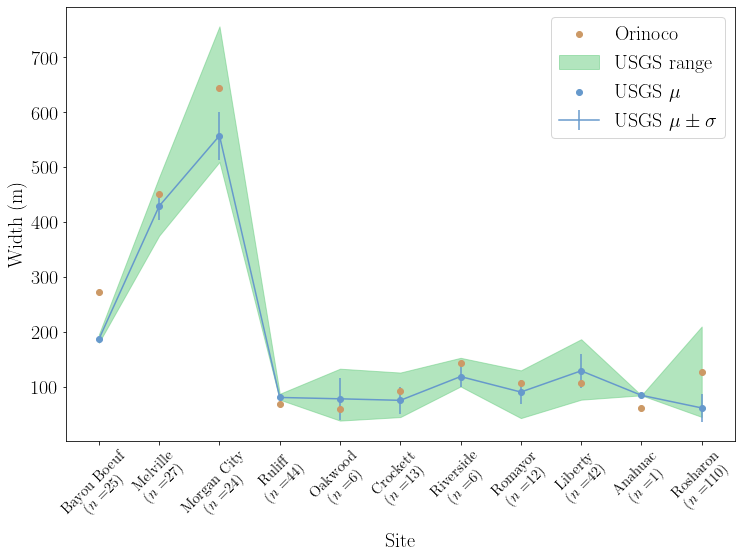

In [28]:
fig, ax = plt.subplots(figsize=(12, 8))

N = 1
df_plot = df_stations_updated.iloc[N:]
xx = np.arange(df_plot.shape[0])

ax.scatter(xx, df_plot.width_m, label='Orinoco', color='#cc9966', zorder=5)

ax.fill_between(xx, df_plot.width_min.values, df_plot.width_max.values, alpha=.5, label='USGS range', color='#66cc7f')
ax.scatter(xx, df_plot.width_mean.values, label='USGS $\mu$', color='#6699cc')
ax.errorbar(xx, df_plot.width_mean.values, df_plot.width_std.values, 
            label='USGS $\mu \pm \sigma$',
            color='#6699cc')

ax.set_xticks(xx)
ax.set_xticklabels(x_ticklabels[N:], rotation = 45, ha="center", fontsize=15)

ax.legend()

ax.set_xlabel('Site')
ax.set_ylabel('Width (m)')

plt.savefig(PLOT_DIR/'usgs_comparison.png')

In [35]:
df_stations_updated['error'] = df_stations_updated.width_mean - df_stations_updated.width_m
df_stations_updated['error_p'] = 100 * (df_stations_updated.width_mean - df_stations_updated.width_m) / df_stations_updated.width_mean

df_stations_updated[['station_name_manual', 'error', 'error_p']]

,station_name_manual,error,error_p
0,"St. Francisville, LA",283.031668,18.642276
1,"Bayou Boeuf, LA",-85.703412,-45.974358
2,"Melville, LA",-21.248061,-4.955793
3,"Morgan City, LA",-86.444397,-15.522567
4,"Ruliff, TX",12.733479,15.869518
5,"Oakwood, TX",17.666153,22.714495
6,"Crockett, TX",-16.514909,-22.025518
7,"Riverside, TX",-24.306112,-20.552696
8,"Romayor, TX",-15.854416,-17.597678
9,"Liberty, TX",22.913436,17.802003


In [9]:
SUBSET_DIR = PLOT_DIR/'stations'
SUBSET_DIR.mkdir(exist_ok=True, parents=True)

100%|██████████| 12/12 [01:17<00:00,  6.44s/it]


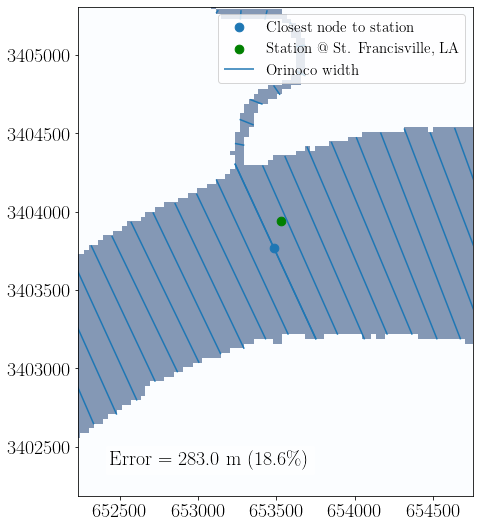

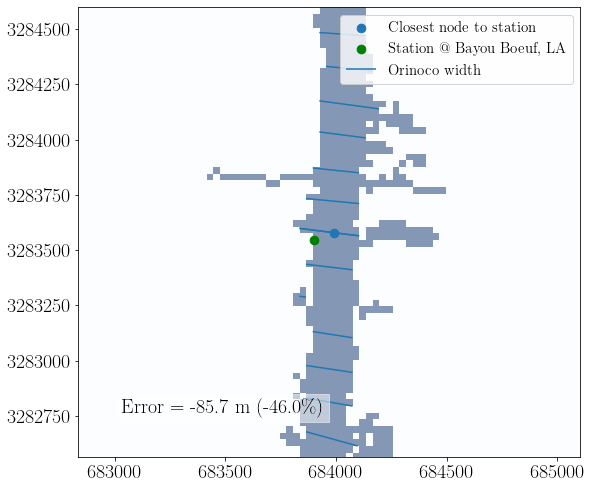

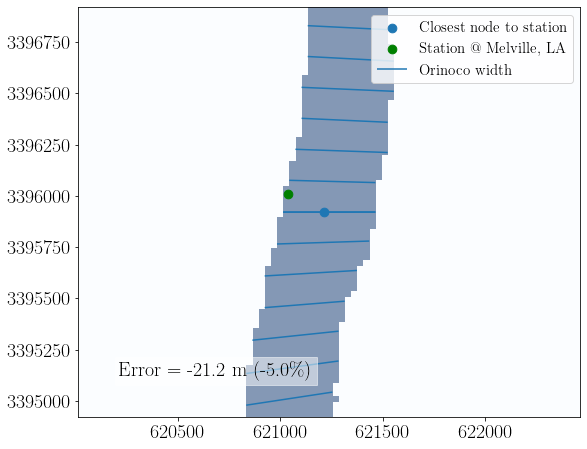

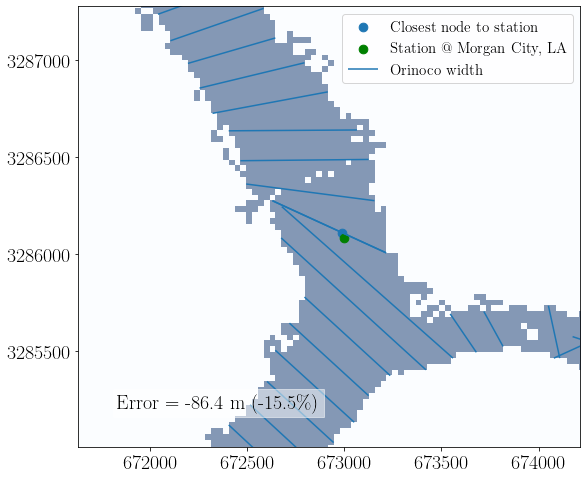

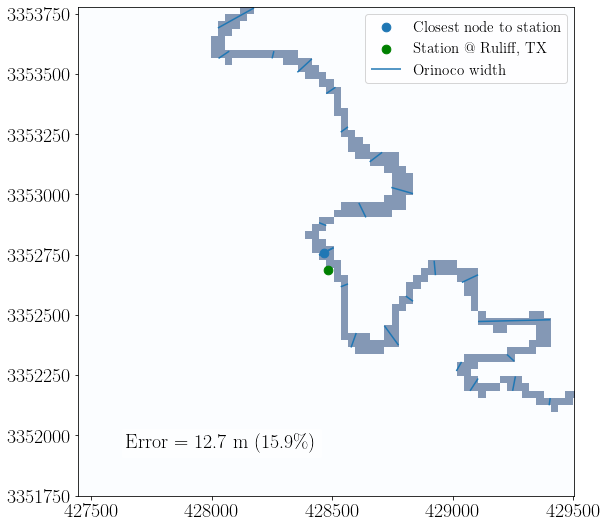

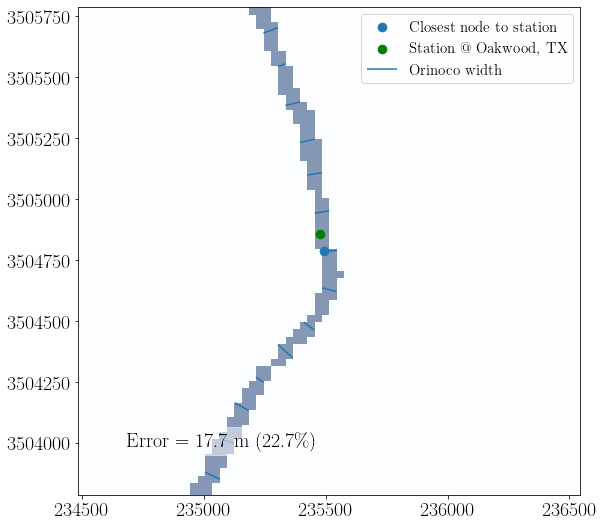

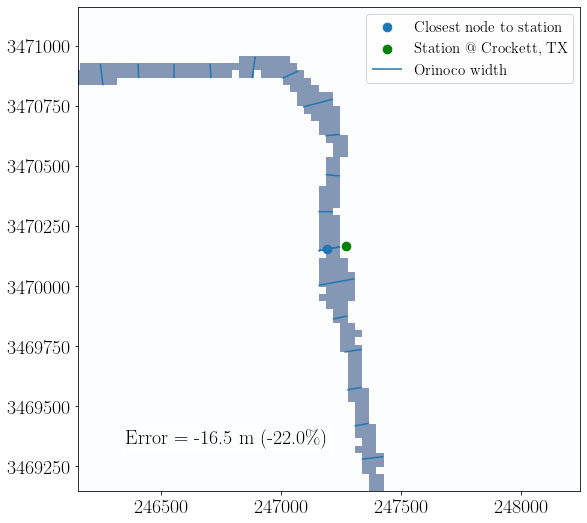

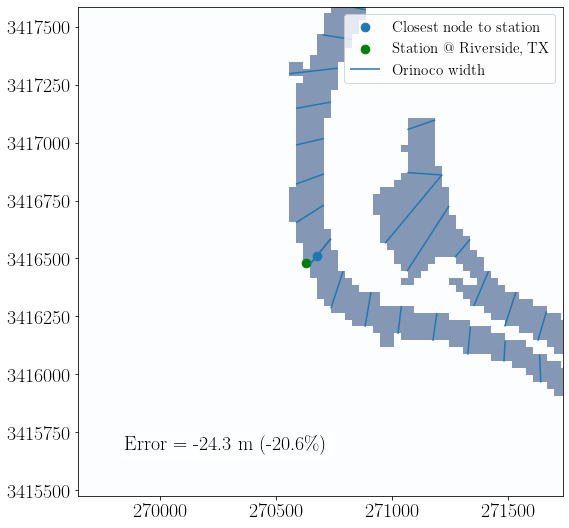

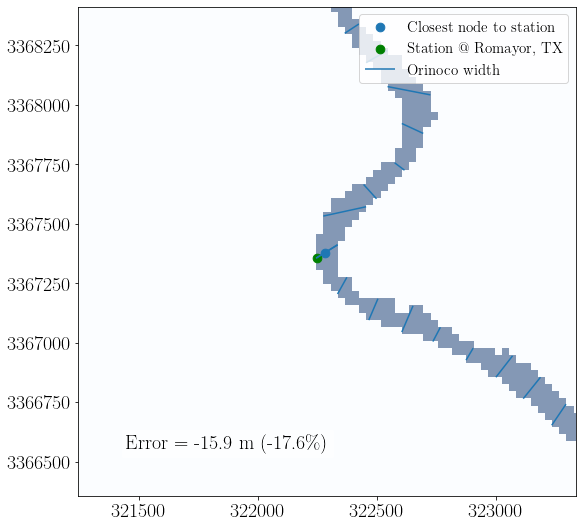

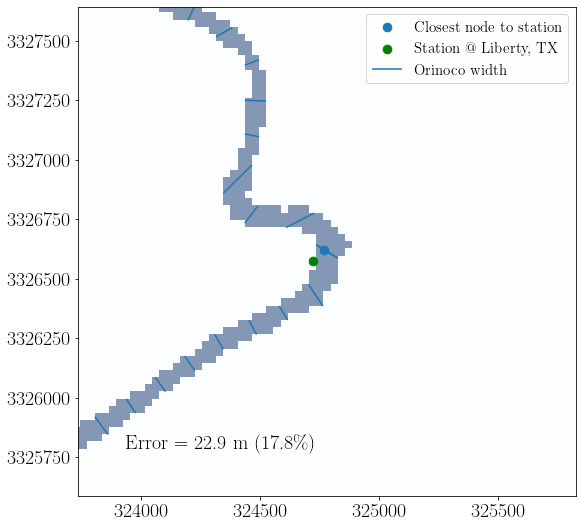

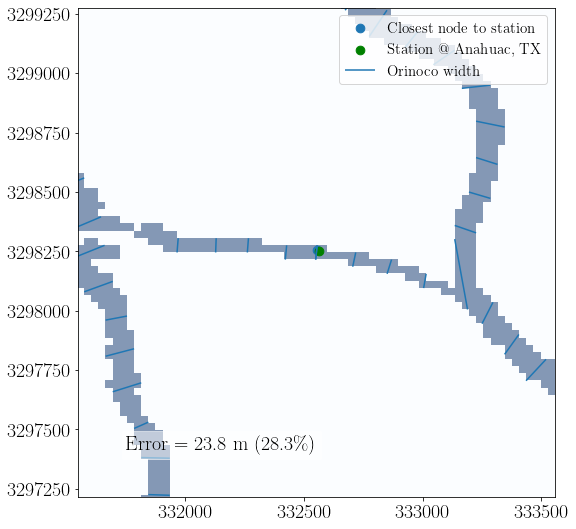

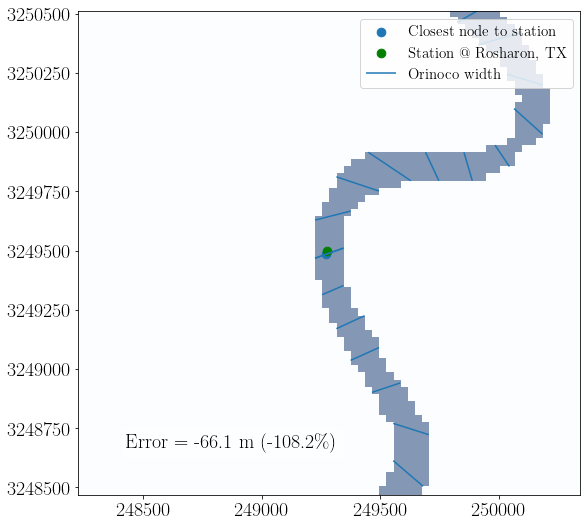

In [38]:
for n in tqdm(df_stations_updated.index):
    fig, ax = plt.subplots(figsize=(9, 9))
    ms = 75
    label = df_stations_updated.iloc[n]['label']
    station_name = df_stations_updated.iloc[n]['station_name_manual']
    df_nodes[df_nodes.label == label].plot(ax=ax, 
                                           markersize=ms,
                                           label='Closest node to station')
    df_width_temp = df_widths[df_widths.label == label]
    df_stations_updated[df_stations_updated.label==label].plot(ax=ax, 
                                                               facecolor='green',
                                                               markersize=ms,
                                                               label=f'Station @ {station_name}')
    df_width_temp.plot(ax=ax, label='Orinoco width')
    xmin, ymin, xmax, ymax = df_width_temp.total_bounds.tolist()
    xlim = xmin-1_000, xmax+1_000
    ylim = ymin-1_000, ymax+1_000
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    df_widths.cx[xlim[0]: xlim[1], ylim[0]: ylim[1]].plot(ax=ax)
    plot.show(water_mask, transform=transform, ax=ax, cmap='Blues', alpha=.5)
    ax.legend(fontsize=15)
    error = df_stations_updated.iloc[n]['error']
    error_p = df_stations_updated.iloc[n]['error_p']
    
    props={'facecolor': 'white',
           'edgecolor': 'white',
           'alpha': .5,}
    ax.text(xlim[0] + 200, ylim[0] + 200, f'Error = {error:1.1f} m ({error_p:1.1f}\%)', bbox=props)

    
    plt.savefig(SUBSET_DIR/f'{fig_names[n]}.png')